In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My\ Drive/Courses/MemNetQA

/content/gdrive/My Drive/Courses/MemNetQA


In [3]:
!pip install transformers

     |████████████████████████████████| 501kB 3.3MB/s 
     |████████████████████████████████| 3.7MB 15.9MB/s 
     |████████████████████████████████| 870kB 17.0MB/s 
     |████████████████████████████████| 1.0MB 30.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=ab167dba8712e63bbca044867829f6bdaa070c2b240d0a54b4c4fcf6adb92401
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [3]:
import pandas as pd
import numpy as np
import datetime
import importlib
import pickle
import time

import data_utils
import model_utils_train
import model_utils_jon
import model_utils_infer
import train_utils
import evaluation
importlib.reload(data_utils)
importlib.reload(model_utils_train)
importlib.reload(model_utils_infer)


importlib.reload(train_utils)
importlib.reload(evaluation)

import torch
import torch.nn as nn

from transformers import DistilBertPreTrainedModel
from transformers import DistilBertForQuestionAnswering
from transformers import DistilBertConfig, DistilBertTokenizer

### Load data

In [0]:
file_dict = {"train1.1tiny": "./data/smaller_data/train5_v1.1.json",
             "train2.0tiny": "./data/tiny_train-v2.0.json",
             "train1.1": "./data/train-v1.1.json", 
             "dev1.1": "./data/smaller_data/dev2_v1.1.json"}
train_data_v1_debug = data_utils.prep_data(file_dict["train1.1tiny"])
train_data_v2_debug = data_utils.prep_data(file_dict["train2.0tiny"])
dev_data_v1 = data_utils.prep_data(file_dict["dev1.1"])
train_data_v1 = data_utils.prep_data(file_dict["train1.1"])

In [12]:
importlib.reload(model_utils_jon)
importlib.reload(train_utils)
m = model_utils_jon.SimpleDistilBERT()
t0 = time.time()
result = train_utils.calculate_score(train_data_v1_debug, m)
t_delta = time.time() - t0
print("inference time ({0} paragraphs): {1:.1f} sec".format(len(train_data_v1_debug), t_delta))
print("f1 score: {}".format(result[1]))

inference time (1011 paragraphs): 22.5 sec
f1 score: OrderedDict([('exact', 0.0), ('f1', 3.1015653012266045), ('total', 1011), ('HasAns_exact', 0.0), ('HasAns_f1', 3.1015653012266045), ('HasAns_total', 1011)])


### Train and run DistilBERT model with simple attention

In [5]:
importlib.reload(model_utils_jon)
importlib.reload(train_utils)
train_list = ['./data/smaller_data/train5_v1.1.json',
              './data/smaller_data/train10_v1.1.json',
              './data/smaller_data/train50_v1.1.json'
              ]
dev_list = ["./data/smaller_data/dev10_v1.1.json"]
exp_results = {"train_f1s": [],
              "val_f1s": [],
              "val_exact_match": [],
              "train_loss": [],
              "val_loss":[],
              "epoch_times":[], 
              "total_times": []}
for data in train_list:
  train_data_v1 = data_utils.prep_data(data)
  dev_data_v1 = data_utils.prep_data(dev_list[0])
  m = model_utils_jon.SimpleDistilBERT()
  result = train_utils.train(train_data=train_data_v1, val_data=dev_data_v1, model=m, patience=5, lr=3e-5, save_checkpt=False)
  exp_results['train_f1s'].append(result['train score'])
  exp_results['val_f1s'].append(result['val f1 score'])
  exp_results['val_exact_match'].append(result["val exact match score"])
  exp_results['epoch_times'].append(result["epoch_time"])

batch 0,Epoch: 0, LR: 3e-05, Train Loss: 10.1005, Val Loss: 9.6900, Val f1 6.461, epoch time: 110.8s
batch 0,Epoch: 1, LR: 3e-05, Train Loss: 9.2341, Val Loss: 9.0623, Val f1 9.009, epoch time: 112.2s
batch 0,Epoch: 2, LR: 3e-05, Train Loss: 7.9762, Val Loss: 7.9508, Val f1 19.667, epoch time: 111.0s
batch 0,Epoch: 3, LR: 3e-05, Train Loss: 6.2593, Val Loss: 6.9784, Val f1 30.498, epoch time: 111.0s
batch 0,Epoch: 4, LR: 3e-05, Train Loss: 4.8521, Val Loss: 7.1096, Val f1 32.540, epoch time: 109.9s
batch 0,Epoch: 5, LR: 3e-05, Train Loss: 3.8777, Val Loss: 6.8800, Val f1 33.312, epoch time: 110.1s
batch 0,Epoch: 6, LR: 3e-05, Train Loss: 3.2054, Val Loss: 7.3088, Val f1 35.895, epoch time: 109.7s
batch 0,Epoch: 7, LR: 3e-05, Train Loss: 2.6668, Val Loss: 7.0572, Val f1 36.340, epoch time: 109.4s
batch 0,Epoch: 8, LR: 3e-05, Train Loss: 2.2624, Val Loss: 7.0817, Val f1 36.238, epoch time: 109.6s
batch 0,Epoch: 9, LR: 3e-05, Train Loss: 1.8743, Val Loss: 6.9614, Val f1 35.312, epoch time

In [0]:
import pickle

with open('experiment_results.pickle', 'wb') as handle:
    pickle.dump(exp_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [8]:
exp_results

{'epoch_times': [[110.81125473976135,
   112.24659824371338,
   110.98049092292786,
   110.99365448951721,
   109.89056396484375,
   110.08527183532715,
   109.6914529800415,
   109.40651369094849,
   109.61654138565063,
   109.3245177268982,
   109.27478122711182,
   108.34651923179626,
   109.0074737071991,
   109.46444654464722,
   109.37978625297546,
   109.62399816513062,
   109.41022157669067,
   109.47302484512329,
   109.02246332168579,
   109.0135600566864,
   108.92458939552307,
   108.74981641769409],
  [149.29447627067566,
   150.5396294593811,
   150.34994077682495,
   148.76055073738098,
   148.32231831550598,
   147.3661985397339,
   146.86080813407898,
   143.57141160964966,
   140.98998045921326,
   141.39054536819458,
   141.93182015419006,
   143.1738977432251,
   145.83573150634766,
   146.34992456436157,
   145.83909487724304,
   145.4217221736908,
   146.4913239479065],
  [627.7488958835602,
   627.0144505500793,
   623.3924386501312,
   624.3774483203888,
   617.

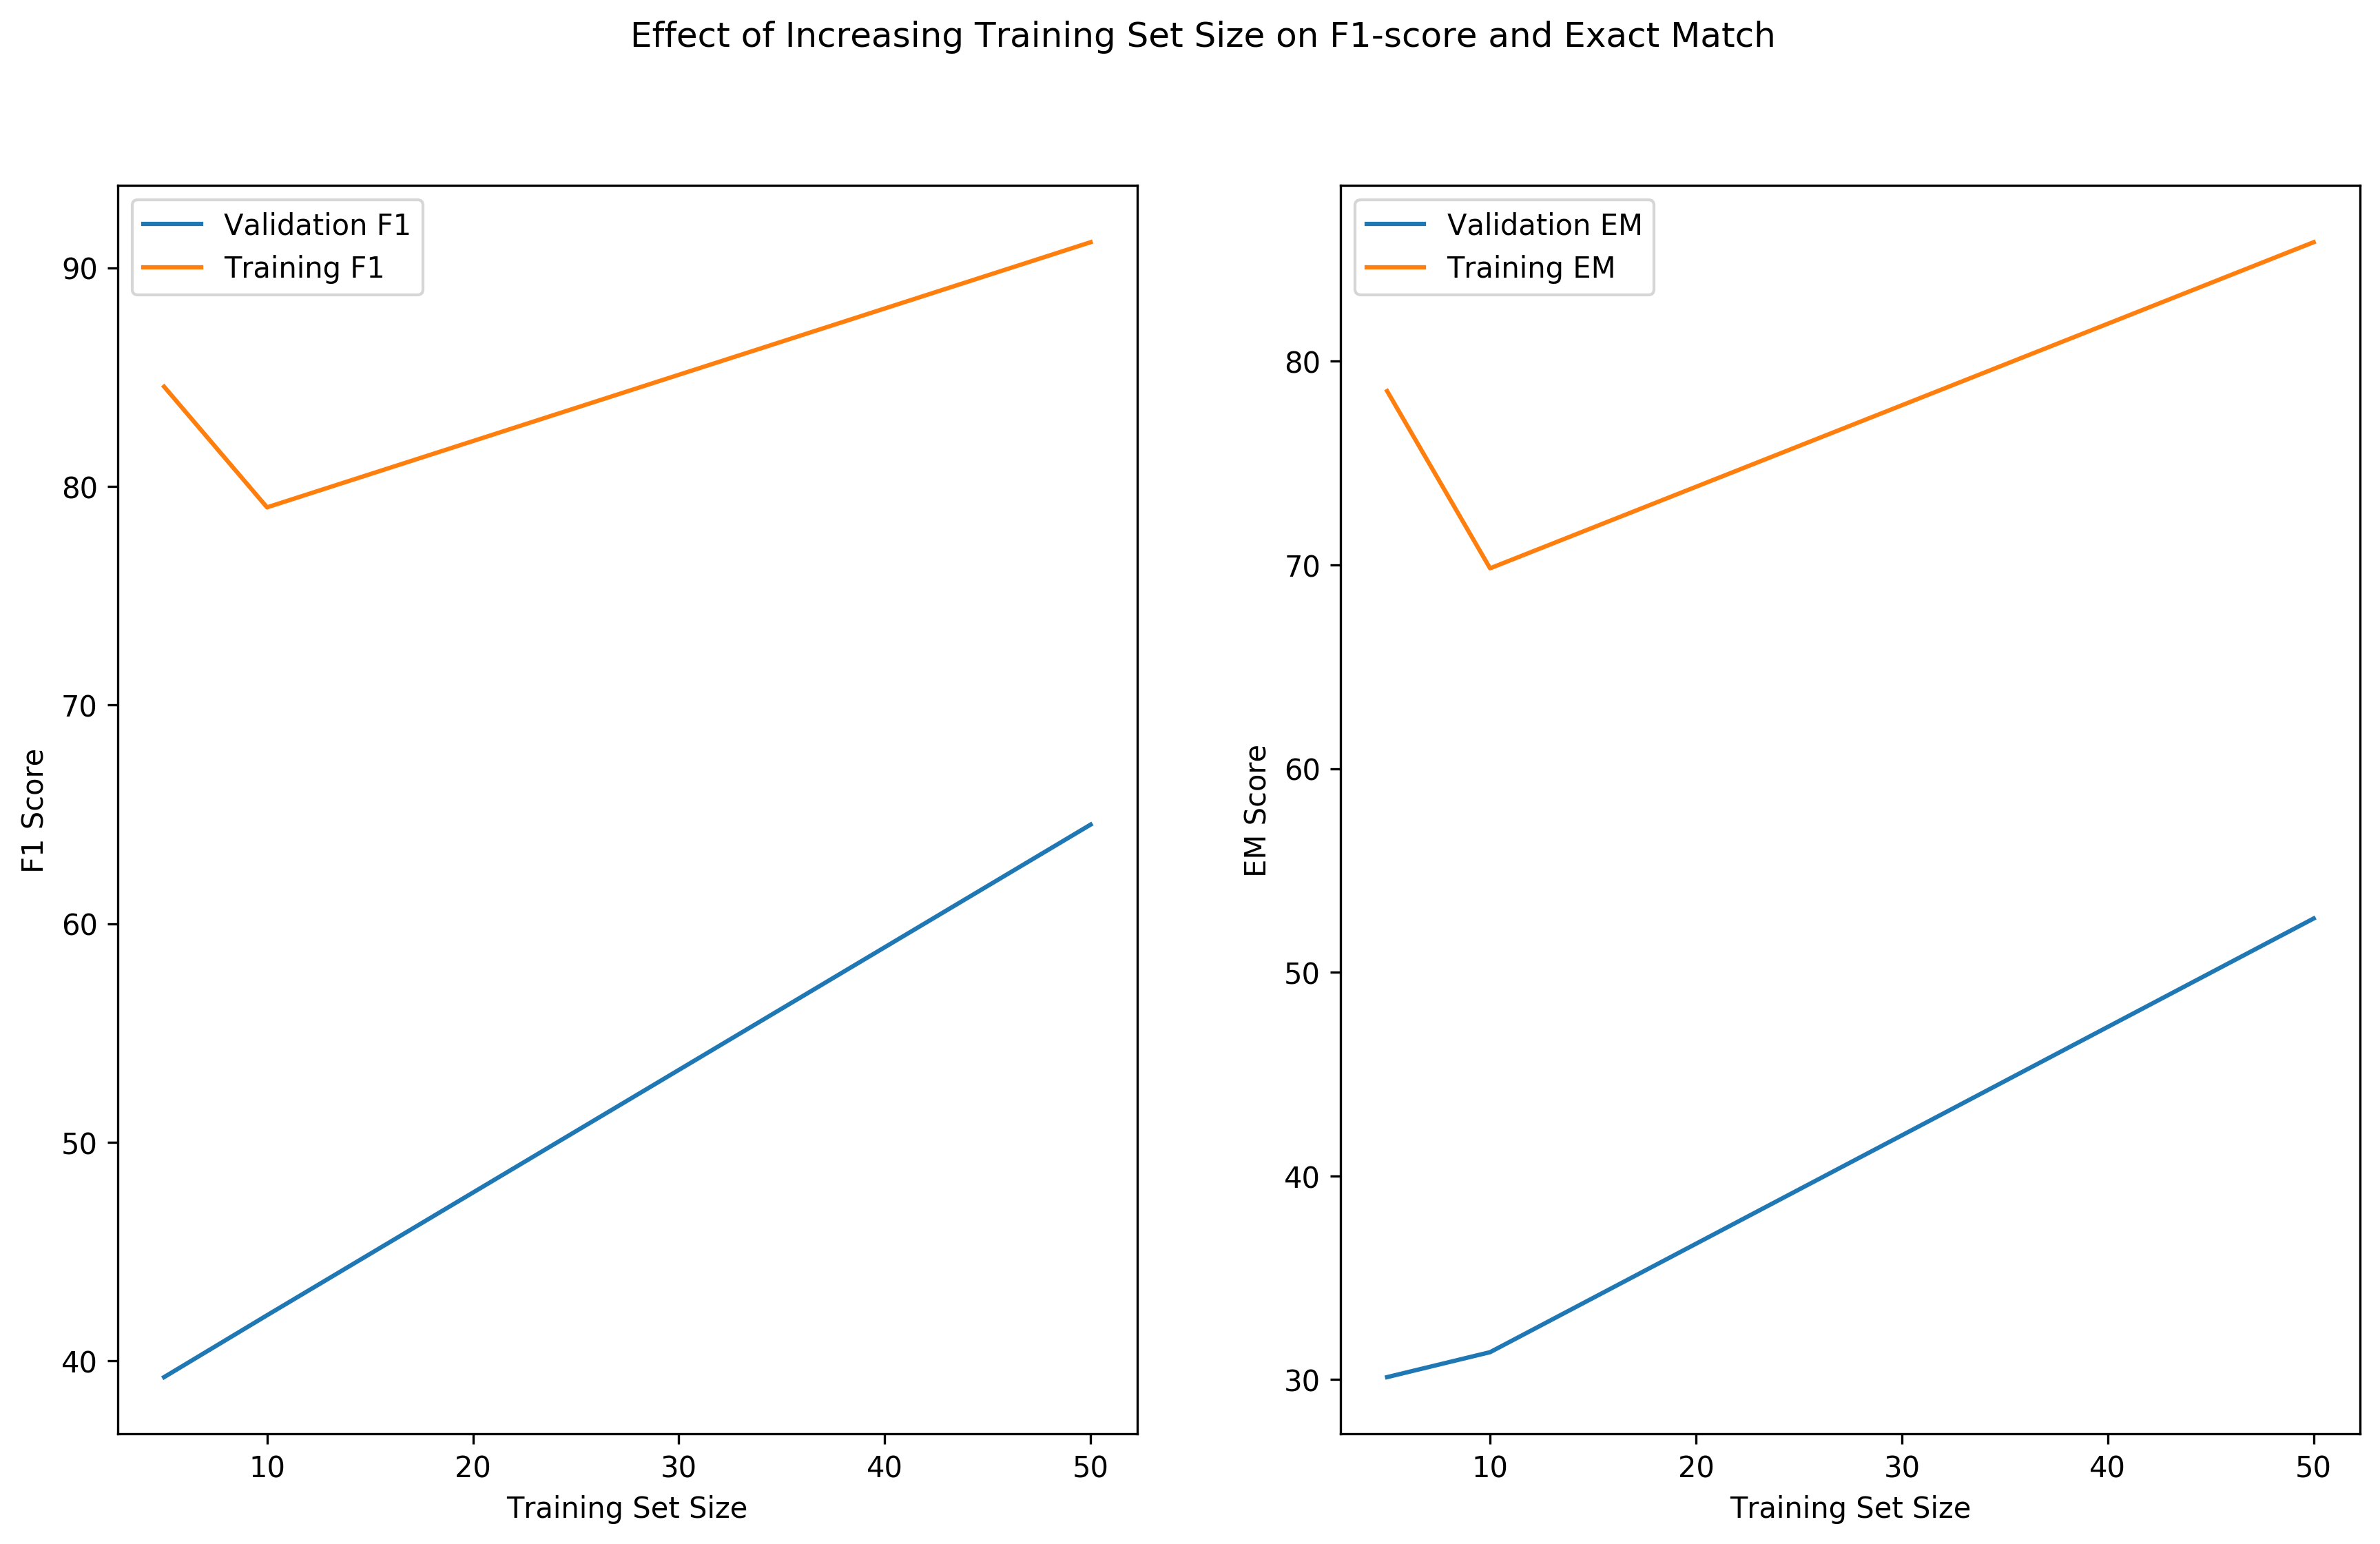

In [35]:
#have plots both F1s scores, exact_match, numer of time to run epochs, size of trainig data
import matplotlib.pyplot as plt
training_sizes = [5, 10, 50]
train_f1s = [exp_results['train_f1s'][i]['f1'] for i in range(len(training_sizes))]
train_ems = [exp_results['train_f1s'][i]['exact'] for i in range(len(training_sizes))]
fig, axs = plt.subplots(1, 2, figsize=(14, 8),dpi=300)
axs[0].plot(training_sizes, exp_results['val_f1s'], label='Validation F1')
axs[0].plot(training_sizes, train_f1s, label='Training F1')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('F1 Score')
axs[0].legend()

axs[1].plot(training_sizes, exp_results['val_exact_match'], label='Validation EM')
axs[1].plot(training_sizes, train_ems, label='Training EM')
axs[1].set_xlabel('Training Set Size')
axs[1].set_ylabel('EM Score')
axs[1].legend()

fig.suptitle("Effect of Increasing Training Set Size on F1-score and Exact Match")
plt.savefig('experiment_plot_50.png')
plt.show()


In [18]:
exp_results['train_f1s'][0]['f1']

84.56287125940467